# TensorFlow Tutorial #03
# Keras API

## Introduction

Tutorial #02 showed how to implement a Convolutional Neural Network in TensorFlow. We made a few helper-functions for creating the layers in the network. It is essential to have a good high-level API because it makes it much easier to implement complex models, and it lowers the risk of errors.

There are several of these builder API's available for TensorFlow: PrettyTensor (Tutorial #03), Layers API (Tutorial #03-B), and several others. But they were never really finished and now they seem to be more or less abandoned by their developers.

This tutorial is about the Keras API which is already highly developed with very good documentation - and the development continues. It seems likely that Keras will be the standard API for TensorFlow in the future so it is recommended that you use it instead of the other APIs.

The author of Keras has written a [blog-post](https://blog.keras.io/user-experience-design-for-apis.html) on his API design philosophy which you should read.

## Flowchart

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below. See Tutorial #02 for a more detailed description of convolution.

There are two convolutional layers, each followed by a down-sampling using max-pooling (not shown in this flowchart). Then there are two fully-connected layers ending in a softmax-classifier.

![Flowchart](images/02_network_flowchart.png)

## Imports 

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

import warnings
warnings.filterwarnings('ignore')

We need to import several things from Keras. Note the long import-statements. This might be a bug. Hopefully it will be possible to write shorter and more elegant lines in the future.

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten


In [3]:
tf.__version__

'1.12.0'

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("./mnist/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/datas

The MNIST data-set has now been loaded and consists of 70.000 images and class-numbers for the images. The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [5]:
print('Size of :')
print('- Training-set : \t\t{}'.format(data.train.num_examples))
print('- Validation-set : \t\t{}'.format(data.validation.num_examples))
print('- Test-set : \t\t\t{}'.format(data.test.num_examples))

Size of :
- Training-set : 		55000
- Validation-set : 		5000
- Test-set : 			10000


Copy some of the data-dimensions for convenience.

In [0]:
# The number of pixels in each dimension of an image.
img_size = 28

# the images are stored in one-dimensional arrays of this length.
img_size_flat = data.train.images[0].shape[0]

# Tuple with height and width of images used to reshape arrays.
img_shape = (28,28)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (28,28,1)

# Number of classes, one class for each of 10 digits.
num_classes = 10

# Number of colour channels for the images : 1 channel for gray-scale.
num_channels = 1

## Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

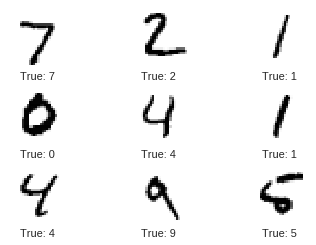

In [8]:
# Get the first images from the Test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = [np.argmax(label) for label in data.test.labels[0:9] ]

# Plot the images and labels using our helper-function above.
plot_images(images= images, cls_true= cls_true)

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [0]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != np.argmax(data.test.labels ,axis=1) )

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = np.argmax(data.test.labels,axis=1)[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## Sequential Model

The Keras API has two models of constructing Neural Networks. The simplest is the Sequential Model which only allows for the layers to be added in sequence.

In [0]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(input_shape = (img_size_flat,)))

# The input is a flattened array with 784 elements,
# but the convolutional layers expect images with shape (28,28,1)
model.add(Reshape(img_shape_full))

# First convolutional layer with ReLU-activation and max-pooling.
model.add( Conv2D(kernel_size=5, strides = 1,
                  filters =16, padding = 'same', activation='relu',
                  name ='layer_conv1') )
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add( Conv2D(kernel_size=5, strides= 1, 
                  filters= 36, padding ='same', activation='relu',
                  name = 'layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer
model.add(Flatten())

# First fully-connected / dense layer with ReLU-activation.
model.add(Dense(128, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(num_classes, activation ='softmax'))

## Model Compilation

The Neural Network has now been defined and must be finalized by adding a loss-function, optimizer and performance metrics. This is called 'compilation' in Keras.

We can either define the optimizer using a string, or if we want more control of its parameters then we need to instantiate an object. For example, we can set the learning-rate.

In [0]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr = 1e-3)

For a classification-problem such as MNIST which has 10 possible classes, we need to use the loss-function called `categorical_crossentropy`. The performance metric we are interested in is the classification accuray.

In [0]:
model.compile( optimizer = optimizer,
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

## Training 

Now that the model has been fully defined with loss-function and optimizer, we can train it. This function takes numpy-arrays and performs the given number of training epochs using the given batch-size. <u>An **epoch** is one full use of the entire Training-set.</u> So for 10 epochs we would iterate randomly over the entire Training-set 10 times.

In [13]:
model.fit(x = data.train.images,
          y = data.train.labels,
          epochs= 1, batch_size= 128)

Epoch 1/1
55000/55000 [==============================] - 8s 150us/step - loss: 0.2198 - acc: 0.9341


## Evalution

Now that the model has been trained we can test its performance on the Test-set. This also uses numpy-arrays as input.

In [14]:
result = model.evaluate(x = data.test.images,
                        y = data.test.labels)

10000/10000 [==============================] - 1s 81us/step


We can print all the performance metrics for the Test-set.

In [17]:
for name, value in zip(model.metrics_names, result):
  print(name, value)

loss 0.05551663102339953
acc 0.9813


Or we can just print the classification accuracy

In [23]:
print('{0} : {1:.2%}'.format(model.metrics_names[1], result[1]))

acc : 98.13%


## Prediction 

We can also predict the classification for new images. We will just use some images from the Test-set but you could load your own images into nupy arrays and use those instead.

In [0]:
images = data.test.images[0:9]

These are the true class-number for those images. This is only used when plotting the images.

In [0]:
cls_true = [np.argmax(label) for label in data.test.labels[0:9] ]

Get the predicted classes as One-Hot encoded arrays.

In [0]:
y_pred= model.predict( x = images)

Get the predicted classes as integers.

In [0]:
cls_pred = np.argmax(y_pred, axis=1)

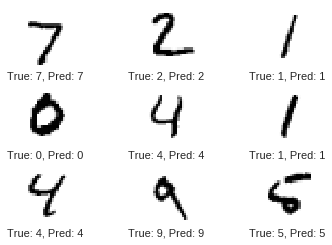

In [32]:
plot_images(images = images,
            cls_true = cls_true,
            cls_pred = cls_pred)

## Examples of Mis-Classified Images

We can plot some examples of mis-classified images from the Test-set. First we get the predicted classes for all the images in the Test-set.

In [0]:
y_pred = model.predict( x = data.test.images)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [0]:
cls_pred = np.argmax(y_pred, axis=1)

Plot some of the mis-classified images.

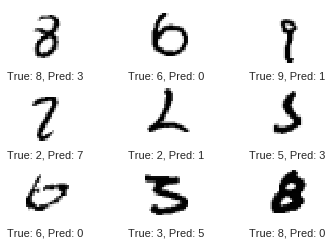

In [43]:
plot_example_errors(cls_pred)

## Functional Model

The Keras API can also be used to construct more complicated networks using the Functional Model. This may look a little confusing at first, because each call to the Keras API will create and return an instance that is itself callable. It is not clear whether it is a function or an object - but we can call it as if it is a function. This allows us to build computational graphs that are more complex than the Sequential Model allows.

In [0]:
# Create an input layer which is similar to a feed_dict in TensorFlow
# Note that the input-shape must be a tuple containing the image-size.
inputs = Input(shape = (img_size_flat,))

# Variable used for building the Neural Network
net = inputs

# The input is an image as a flattened array with 784 elements.
# But the convolutional layers expect images with shape (28,28,1)
net = Reshape(img_shape_full)(net)

# First convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides =1, filters= 16,
             padding='same', activation ='relu', name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Second convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters= 36, 
             padding='same', activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Flatten the output of the conv-layer from 4-dim to 2-dim.
net = Flatten()(net)

# First fully-connected / dense layer with ReLU-activation.
net = Dense(128, activation = 'relu')(net)

# Last fully-connected / dense layer with softmax-activation
# so it can be used for classification.
net = Dense(num_classes, activation='softmax')(net)

# Output of the Neural Network.
outputs = net

### Model Compilation

We have now defined the architecture of the model with its input and output. We now have to create a Keras model and compile it with a loss-function and optimizer, so it is ready for training.

In [0]:
from tensorflow.python.keras.models import Model

Create a new instance of the Keras Functional Model. We give it the inputs and outputs of the Convolutional Neural Network that we constructed above.

In [0]:
model2 = Model(inputs= inputs, outputs= outputs)

Compile the Keras model using the RMSprop optimizer and with a loss function for multiple categories. The only performance metric we are interested in is the classification accuracy, but you could use a list of metrics here.

In [0]:
model2.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

### Training

The model has now been defined and compiled so it can be trained using the same `fit()` function as used in the Sequential Model above. This also takes numpy-arrays as input.

In [64]:
model2.fit( x = data.train.images,
            y = data.train.labels,
            epochs=1, batch_size=128)

Epoch 1/1
55000/55000 [==============================] - 4s 79us/step - loss: 0.2011 - acc: 0.9383


### Evaluation

Once the model has been trained we can evaluate its performance on the test-set. This is the same syntax as for the Sequential Model.

In [65]:
result = model2.evaluate( x = data.test.images,
                          y = data.test.labels,
                          )

10000/10000 [==============================] - 1s 82us/step


The result is a list of values, containing the loss-value and all the metrics we defined when we compiled the model. Note that 'accuracy' is now called 'acc' which is a small inconsistency.

In [67]:
for name, value in zip(model2.metrics_names, result):
  print(name, value)

loss 0.052775900065968745
acc 0.9821


We can also print the classification accuracy as a percentage:

In [68]:
print("{0}: {1:.2%}".format(model2.metrics_names[1], result[1]))

acc: 98.21%


### Examples of Mis-Classified Images



We can plot some examples of mis-classified images from the test-set.

First we get the predicted classes for all the images in the test-set:

In [0]:
y_pred = model2.predict(x = data.test.images)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [0]:
cls_pred = np.argmax(y_pred, axis=1)

Plot some of the mis-classified images.

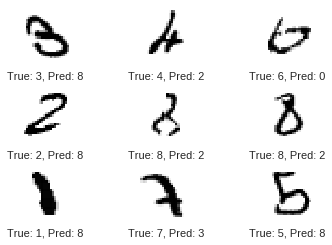

In [72]:
plot_example_errors(cls_pred)

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.